<a href="https://colab.research.google.com/github/soumilhooda/MLDLNNtoCV/blob/main/Q8_NNFL_Assignment2_SoumilHooda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import math
import numpy as np
import random
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import files
uploaded = files.upload()

Saving data5.xlsx to data5.xlsx


In [3]:
qdata = data = pd.read_excel('data5.xlsx',header=None)
qdata = qdata.sample(frac=1).reset_index(drop=True)

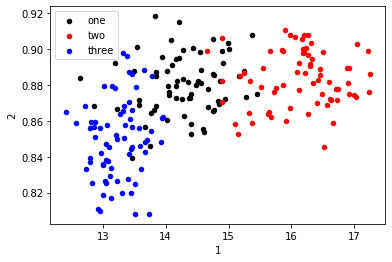

In [14]:
class_one = qdata[qdata[7]==1][0:211]
class_two = qdata[qdata[7]==2][0:211]
class_three = qdata[qdata[7]==3][0:211]
axes = class_one.plot(kind='scatter', x=1, y=2, color='black', label='one')
class_two.plot(kind='scatter', x=1, y=2, color='red', label='two', ax=axes)
class_three.plot(kind='scatter', x=1, y=2, color='blue', label='three', ax=axes)

In [5]:
sheet1 =pd.read_excel('data5.xlsx',header=None)
data = sheet1.values
np.random.shuffle(data)
x = data[0: , :-1]
x = (x - np.min(x,axis=0))/(np.max(x,axis=0)- np.min(x,axis=0))
y = data[0: , -1]
x_train,X_test,y_train,y_test = train_test_split(x, y, test_size= 0.2 )

In [6]:
def one_vs_all(y):
  y_model1 = []
  y_model2 = []
  y_model3 = []
  for ele in y:
    if (ele == 1):
      y_model1.append(1)
      y_model2.append(-1)
      y_model3.append(-1)
    if (ele == 2):
      y_model1.append(-1)
      y_model2.append(1)
      y_model3.append(-1)
    if (ele == 3):
      y_model1.append(-1)
      y_model2.append(-1)
      y_model3.append(1)
  return y_model1,y_model2,y_model3

In [7]:
def train_lin_sum (x_tr,y_tr,C,bound,maxiters):
  m = x_tr.shape[0]
  n = x_tr.shape[1]
  b = 0
  mu = np.ones((m,1))
  E = np.zeros((m,1))
  iter = 0 
  eta =0
  L =0
  H = 0
  kernel = lambda xi, yi: math.pow((np.dot(xi.T, yi) + 1), 2)
  while iter<maxiters:
    count_mu = 0
    for i in range(m):
      E[i] = f_x(x_tr, y_tr, mu, b, x_tr[i, :], 2) - y_tr[i]
      if (y_tr[i]*E[i]<-bound and mu[i]<C) or (y_tr[i]*E[i]>bound and mu[i]>0):
        j = math.floor(m*np.random.rand())
        while j == i:
          j = math.floor(m*np.random.rand())
        E[j] = f_x(x_tr, y_tr, mu, b, x_tr[j, :], 2) - y_tr[j]
        mu_i_old = mu[i]
        mu_j_old = mu[j]
        if y_tr[i] == y_tr[j]:
          L = max(0, mu[i]+mu[j]-C)
          H = min(C,mu[i]+mu[j])
        else:
          L = max(0,mu[j]-mu[i])
          H = min(C,C+mu[j]-mu[i])
        if (L == H):
          continue
        eta = 2*kernel(x_tr[i, :], x_tr[j, :]) - kernel(x_tr[i, :], x_tr[i, :]) - kernel(x_tr[j, :], x_tr[j, :])
        if eta>=0:
          continue
        mu[j] = mu[j] - (y_tr[j]*(E[i]-E[j]))/eta
        mu[j] = min(H,mu[j])
        mu[j] = max(L,mu[j])
        if abs(mu[j]-mu_j_old)<bound:
          mu[j] = mu_j_old
          continue
        mu[i] = mu[i]+y_tr[i]*y_tr[j]*(mu_j_old-mu[j])
        b1 = b - E[i]- (y_tr[i]*(mu[i]-mu_i_old)*kernel(x_tr[i, :], x_tr[i, :]))  - (y_tr[j]*(mu[j]-mu_j_old)*kernel(x_tr[i, :], x_tr[j, :]))
        b2 = b - E[j]- (y_tr[i]*(mu[i]-mu_i_old)*kernel(x_tr[i, :], x_tr[j, :])) - (y_tr[j]*(mu[j]-mu_j_old)*kernel(x_tr[j, :], x_tr[j, :]))
        if (0<mu[i]) and (mu[i]<C):
          b = b1
        elif (0<mu[j]) and (mu[j]<C):
          b = b2
        else:
          b = (b1+b2)/2
        count_mu = count_mu +1
    if (count_mu == 0):
      iter = iter+1
    else:
      iter = 0
  il1 = mu>0
  Xsvm = []
  Ysvm = []
  mus = []
  for v in range(len(il1)):
    if il1[v]:
      Xsvm.append(x_tr[v,:])
      Ysvm.append(y_tr[v])
      mus.append(mu[v])
  Xsvm = np.array(Xsvm)
  Ysvm = np.array(Ysvm)
  mus = np.array(mus)
  w = np.zeros(7)
  num_sv = Xsvm.shape[1]
  for l in range(7):
    w += mus[l]*Ysvm[l]*((1 + Xsvm[l,:])**2)
  return w,b,Xsvm,Ysvm,mus,num_sv

In [8]:
def f_x(X, y, a, b, x, degree):
    predicted_value = 0.0
    # using polynomial kernel
    for k in range(X.shape[0]):
        predicted_value += (a[k]*y[k]*((X[k, :].T@x + 1)**degree))
    return predicted_value + b

In [9]:
def sigmoid(z):
  return 1.0 / ( 1.0 + np.exp(-z))

In [10]:
def prediction(xs,ys,x_ts,mean,bias,n_svm):
  yp = 0
  for s in range(n_svm):
    yp += (mean[s]*ys[s]*np.dot(x_ts,xs[s]))
  return np.sign(yp+bias)

In [11]:
C = 50
iters =150
p_outputs = []
y_tr1,y_tr2,y_tr3 = one_vs_all(y_train)
y_ts1,y_ts2,y_ts3 = one_vs_all(y_test)
w1,b1,x1,y1,m1,n1= train_lin_sum(x_train,y_tr1,C,0.001,iters)
w2,b2,x2,y2,m2,n2= train_lin_sum(x_train,y_tr2,C,0.001,iters)
w3,b3,x3,y3,m3,n3= train_lin_sum(x_train,y_tr3,C,0.001,iters)

In [12]:
yp1 = []
yp2 = []
yp3 = []
lis = [-1,1]
for b in range(len(X_test)):
  if f_x(x1, y1, m1, b1, X_test[b, :], 4) >= 0:
    yp1.append(1.0)
  else:
    yp1.append(-1.0)
  if f_x(x2, y2, m2, b2, X_test[b, :], 4) >= 0:
    yp2.append(1.0)
  else:
    yp2.append(-1.0)
  if f_x(x3, y3, m3, b3, X_test[b, :], 4) >= 0:
    yp3.append(1.0)
  else:
    yp3.append(-1.0)

In [13]:
y_actual1 = pd.Series(y_ts1, name= 'Actual' )
y_pred1 = pd.Series(y1, name= 'Predicted' )
confmat1 = pd.crosstab(y_actual1,y_pred1)
y_actual2 = pd.Series(y_ts2, name= 'Actual' )
y_pred2 = pd.Series(y2, name= 'Predicted' )
confmat2 = pd.crosstab(y_actual2,y_pred2)
y_actual3 = pd.Series(y_ts3, name= 'Actual' )
y_pred3 = pd.Series(y3, name= 'Predicted' )
confmat3 = pd.crosstab(y_actual3,y_pred3)
print("Class 1:\n", confmat1)
print("Class 2:\n", confmat2)
print("Class 3:\n", confmat3)

Class 1:
 Predicted  -1   1
Actual           
-1         27   2
 1         11   2
Class 2:
 Predicted  -1   1
Actual           
-1         19   4
 1         14   5
Class 3:
 Predicted  -1   1
Actual           
-1         16   3
 1          7   0
